### Imports & Utils

In [0]:
!pip install --upgrade -q https://storage.googleapis.com/jax-wheels/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-0.1.12-cp36-none-linux_x86_64.whl
!pip install --upgrade -q jax
!pip install -q git+https://www.github.com/google/jax-md

In [0]:
import numpy as onp

import jax.numpy as np
from jax import random
from jax import jit
key = random.PRNGKey(0)

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

In [121]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

background_color = [0.85, 0.85, 0.9]

def format_plot(x, y):  
  plt.gca().set_axis_bgcolor(background_color)
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_schsam.kernel.schsam.135420007890.14b334fb3717c109/mount/server/dm_notebook.par/google3/third_party/py/matplotlib/__init__.py:1590: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Constant Temperature Simulation

Here we demonstrate some code to run a simulation at in the NVT ensemble. We start off by setting up some parameters of the simulation. This will include a temperature schedule that will start off at a high temperature and then instantaneously quench to a lower temperature.

In [0]:
N = 5000
dimension = 2
box_size = 80.0
dt = 1e-3
displacement, shift = space.periodic(box_size) 

T_schedule = lambda t: np.where(t < 1000.0 * dt, 1.0, 0.4)

Next we need to generate some random positions as well as particle sizes.

In [0]:
key, split = random.split(key)
R = random.uniform(
    split, (N, dimension), minval=0.0, maxval=box_size, dtype=np.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = np.where(np.arange(N) < N_2, 0, 1)

Then we need to construct our simulation operators.

In [0]:
energy_fn = jit(energy.soft_sphere_pairwise(
    displacement, species=species, sigma=sigma, epsilon=10.0))

init, apply = simulate.nvt_nose_hoover(energy_fn, shift, dt, T_schedule)
apply = jit(apply)
state = init(key, R)

Now let's actually do the simulation. We'll keep track of the temperature as well as the extended Hamiltonian of the Nose-Hoover dynamics.

In [0]:
def invariant(T, state):
  """The conserved quantity for Nose-Hoover thermostat."""
  accum = energy_fn(state.position) + \
          quantity.kinetic_energy(state.velocity, state.mass)
  N, dim = state.position.shape
  DOF = N * dim
  accum = accum + state.v_xi[0] ** 2 * state.Q[0] * 0.5 + \
      DOF * T * state.xi[0]
  for xi, v_xi, Q in zip(
      state.xi[1:], state.v_xi[1:], state.Q[1:]):
    accum = accum + v_xi ** 2 * Q * 0.5 + T * xi
  return accum

In [134]:
T = []
H = []

print_every = 50
old_time = time.clock()
print('Step\tT_goal\tT\ttime/step')
print('----------------------------------------')

for i in range(2000):
  t = i * dt
  state = apply(state, t=t)
  T += [quantity.temperature(state.velocity)]
  H += [invariant(T_schedule(t), state)]
  state = apply(state, t=t)
  
  if i % print_every == 0 and i > 0:
    new_time = time.clock()
    print('{}\t{:.2f}\t{:.2f}\t{:.3f}'.format(
        i, T_schedule(t), T[-1], (new_time - old_time) / print_every))
    old_time = new_time
    
T = np.array(T)
H = np.array(H)
R = state.position

Step	T_goal	T	time/step
----------------------------------------
50	1.00	1.02	0.126
100	1.00	1.02	0.067
150	1.00	1.00	0.060
200	1.00	1.00	0.056
250	1.00	0.98	0.056
300	1.00	1.02	0.056
350	1.00	1.02	0.056
400	1.00	0.99	0.056
450	1.00	1.00	0.056
500	1.00	0.99	0.056
550	1.00	1.02	0.057
600	1.00	1.01	0.056
650	1.00	0.98	0.057
700	1.00	0.98	0.057
750	1.00	1.00	0.056
800	1.00	1.02	0.056
850	1.00	1.00	0.056
900	1.00	0.98	0.056
950	1.00	1.00	0.056
1000	0.40	1.00	0.056
1050	0.40	0.41	0.056
1100	0.40	0.40	0.057
1150	0.40	0.40	0.056
1200	0.40	0.40	0.057
1250	0.40	0.40	0.056
1300	0.40	0.40	0.056
1350	0.40	0.40	0.056
1400	0.40	0.40	0.065
1450	0.40	0.40	0.067
1500	0.40	0.40	0.070
1550	0.40	0.40	0.072
1600	0.40	0.41	0.072
1650	0.40	0.40	0.072
1700	0.40	0.40	0.060
1750	0.40	0.38	0.060
1800	0.40	0.40	0.061
1850	0.40	0.40	0.061
1900	0.40	0.40	0.061
1950	0.40	0.40	0.061


Now, let's plot the temperature as a function of time. We see that the temperature tracks the goal temperature with some fluctuations.

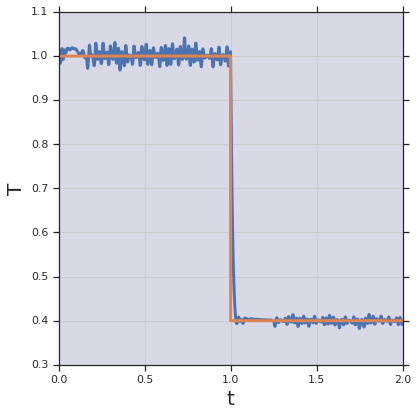

In [135]:
t = onp.arange(0, 2000) * dt
T = onp.array(T)
plt.plot(t, T, linewidth=3)
plt.plot(t, onp.array(T_schedule(t)), linewidth=3)
format_plot('t', 'T')
finalize_plot()

Now let's plot the Hamiltonian of the system. We see that it is invariant apart from changes tot he temperature, as expected.

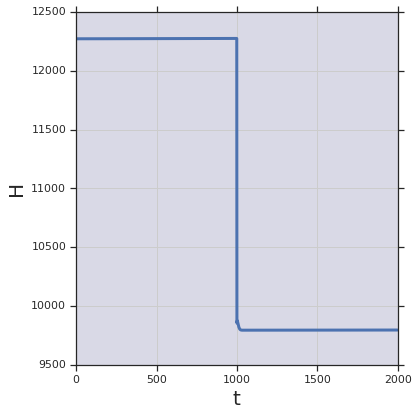

In [136]:
plt.plot(H, linewidth=3)
format_plot('t', 'H')
finalize_plot()

Now let's plot the system.

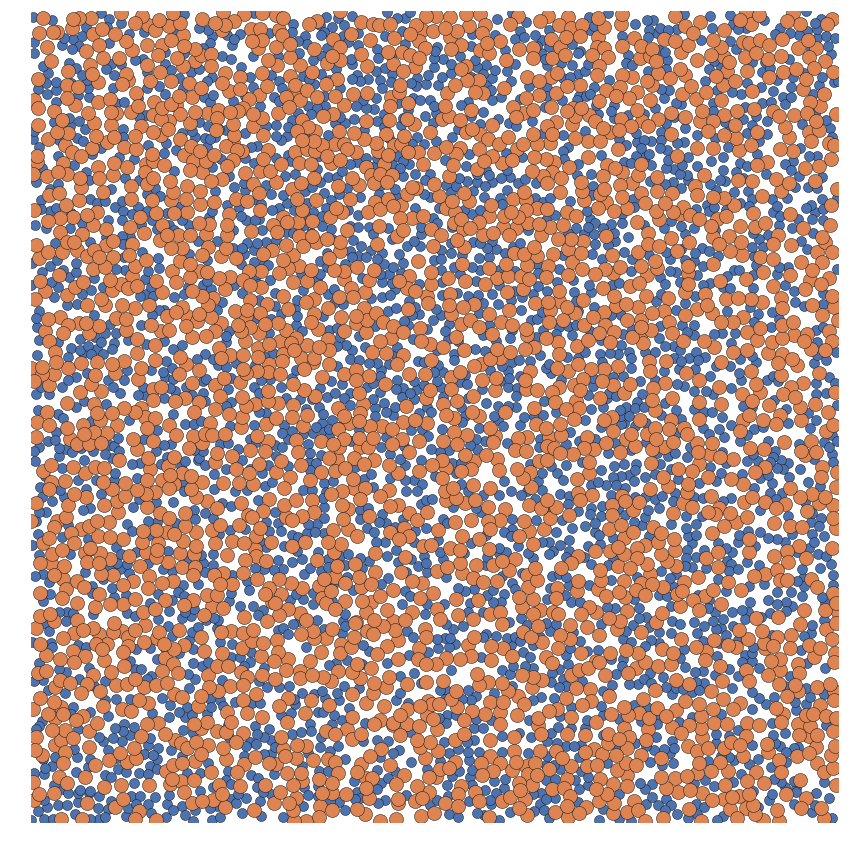

In [137]:
ms = 20
R_plt = onp.array(state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

Finally, let's plot the velocity distribution compared with its theoretical prediction.

In [0]:
V_flat = onp.reshape(onp.array(state.velocity), (-1,))
occ, bins = onp.histogram(V_flat, bins=100, normed=True)

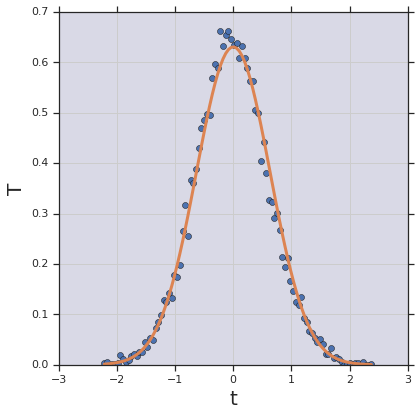

In [139]:
T_cur = T_schedule(20.0)
plt.plot(bins[:-1], occ, 'o')
plt.plot(
    bins[:-1], 
    1.0 / np.sqrt(2 * np.pi * T_cur) * onp.exp(-1/(2 * T_cur) * bins[:-1] ** 2), 
    linewidth=3)
format_plot('t', 'T')
finalize_plot()